# Info

In this notebook we use the Lennard-Jones toysystem we created in `lennard_jones_toysystem.ipynb` to play around a bit and learn something about the time reversibility of integrators.

Simulate a cube of particles and reverse the velocities after some time so it returns to the original state.

```
+----------+      +----------+      +----------+
|          |  t   |   X   X  | -t   |          |
|    XX    |  =>  |          |  =>  |    XX    | 
|    XX    |      |    X     |      |    XX    | 
|          |      |  X       |      |          |
+----------+      +----------+      +----------+
```

## Targets
* create cube of gas molecules
* ideal gas: reversible integrator
* real gas: reversible integrator

In [7]:
from simtk import openmm as mm
from simtk.openmm import app
from simtk.unit import *
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import mdtraj
import nglview

from copy import deepcopy

# Input

Let's define our input which is used for both the *ideal* and the *real* gas.

## Interactions

Parameters to define the interactions between the gas atoms. 

Only used for the real gas.

In [8]:
mass = 39.9 * amu
charge = 0.0 * elementary_charge
sigma = 3.4 * angstroms
epsilon = 0.238 * kilocalories_per_mole

## System

Define the box size and the number of particles per cube side and with it the total number of particles.

In [9]:
n_particles_per_side = 4
n_particles = n_particles_per_side ** 3 
box_size = 60 * angstrom

## MD - Settings

Define some MD parameters.

In [10]:
# time step
timestep = 1.0 * femtoseconds

# number of simulated steps
n_steps = 10000

# output frequency
n_output = 100

# Ideal gas

In an ideal gas we do not have any interactions so we will just create the system and skip the force part.

## Create the simulation

### System

In [11]:
# Create a system and add particles to it
system = mm.System()
for index in range(n_particles):
    # Particles are added one at a time
    # Their indices in the System will correspond with their indices in the Force objects we will add later
    system.addParticle(mass)
    
box_vectors = np.diag([box_size/angstrom for i in range(3)])*angstrom
system.setDefaultPeriodicBoxVectors(*box_vectors)

### Forces

In [12]:
# NO FORCES HERE

### Integrator

In [13]:
# Create an integrator
integrator = mm.VerletIntegrator(timestep)

### Topology

In [14]:
top = app.Topology()
chain = top.addChain()
for i in range(n_particles):
    residue = top.addResidue(name='Ar', chain=chain, id=i)
    top.addAtom('Ar',element=app.Element.getBySymbol('Ar') , residue=residue)
top.setPeriodicBoxVectors(box_vectors)
print(top) 

<Topology; 1 chains, 64 residues, 64 atoms, 0 bonds>


### Create the simulation

In [15]:
simulation = app.Simulation(topology=top, system=system, integrator=integrator)

### Define starting positions

We create the cube by iterating in all room directions for our number of particles.

The distance `r0` between the particles is defined as their minimum in the Lennard-Jones potential.

In [16]:
positions = np.zeros((n_particles, 3), dtype=np.float64)

# radius where the lennard jones potential is zero
r0 = (sigma * 2**(1./6.))/angstrom

# set coordinates
i = 0 # atom index
for x in range(n_particles_per_side):
    for y in range(n_particles_per_side):
        for z in range(n_particles_per_side):
            positions[i] = (x*r0, y*r0, z*r0)
            # update atom count
            i+=1 

# calculate center of geometry
center_of_geometry = np.sum(positions, axis=0) / n_particles
# calculate box center (only for orthogonal boxes !)
box_half = np.ones(3) * box_size.value_in_unit(angstrom) / 2
# shift center of geometry in the middle of the box
positions += box_half - center_of_geometry

positions = Quantity(positions, unit=angstrom)

set positions

In [17]:
simulation.context.setPositions(positions )

### Visualize

Let's view what we created.

In [18]:
mdtraj_topology = mdtraj.Topology.from_openmm(simulation.topology)
traj = mdtraj.Trajectory(positions/nanometers, mdtraj_topology,
                         unitcell_lengths=[box_size/nanometers, box_size/nanometers, box_size/nanometers],
                         unitcell_angles=[90, 90, 90])
view = nglview.show_mdtraj(traj, use_box=True) # gui=True for more options

view.add_spacefill('all')
view.add_unitcell()
# update camera type
view.camera = 'orthographic'

view.center()
view

NGLWidget()

### Velocities

Define velocities and store them in an array for later use.

In [19]:
simulation.context.setVelocitiesToTemperature(300 * kelvin)
state = simulation.context.getState(getVelocities=True)
velocities_start = deepcopy(state.getVelocities(asNumpy=True))

### Reporters

In [20]:
simulation.reporters.append(app.StateDataReporter('thermo.reversible.idealgas.csv', n_output,
                                                  step=True,
                                                  potentialEnergy=True,
                                                  kineticEnergy=True,
                                                  totalEnergy=True,
                                                  temperature=True,
                                                 ))
simulation.reporters.append(app.DCDReporter("trajectory.reversible.idealgas.dcd", n_output, enforcePeriodicBox=True))

## Simulation

At first we store the first state of the system.

In [21]:
# store positions
state = simulation.context.getState(getPositions=True)
positions_start = deepcopy(state.getPositions(asNumpy=True))
                           
# write first frame to dcd file
simulation.reporters[1].report(simulation, state)

### Forward

Let's run the simulation for `n_steps` in the forward direction.

In [22]:
simulation.step(n_steps)

#### Visualize

In [23]:
mdtraj_topology = mdtraj.Topology.from_openmm(simulation.topology)
traj = mdtraj.load_dcd('trajectory.reversible.idealgas.dcd', top=mdtraj_topology)
view = nglview.show_mdtraj(traj, use_box=True) # gui=True for more options

view.add_spacefill('all')
view.add_unitcell()
# update camera type
view.camera = 'orthographic'

view.center()
view

NGLWidget(count=101)

As expected the cube is not a stable structure for an ideal gas at 300 Kelvin.

### Backward

Let's run the simulation for `n_steps` backward in time.

Therefore, we need to reverse the velocities of our system.

get the velocities

In [24]:
state = simulation.context.getState(getVelocities=True)
velocities = state.getVelocities(asNumpy=True)

reverse the velocities

In [25]:
simulation.context.setVelocities(velocities * -1)

run the simulation

In [26]:
simulation.step(n_steps)

### Visualize

In [27]:
mdtraj_topology = mdtraj.Topology.from_openmm(simulation.topology)
traj = mdtraj.load_dcd('trajectory.reversible.idealgas.dcd', top=mdtraj_topology)
view = nglview.show_mdtraj(traj, use_box=True) # gui=True for more options

view.add_spacefill('all')
view.add_unitcell()
# update camera type
view.camera = 'orthographic'

view.center()
view

NGLWidget(count=201)

As you can see, our system is able to return into the starting state.

### Check positions

Additionally, we can check if our positions are exactly the same.

In [28]:
# get the positions at the end
state = simulation.context.getState(getPositions=True)
positions_end = state.getPositions(asNumpy=True)

In [53]:
not_the_same = np.argwhere(
    (positions_start.value_in_unit(angstrom) - positions_end.value_in_unit(angstrom)) != 0)
atom_i, pos_i = not_the_same[0]

In [61]:
print("Positions at the start / end of atom {}\n(different in {}-direction)".format(atom_i, "xyz"[pos_i]))
print(positions_start[atom_i].in_units_of(angstrom))
print(positions_end[atom_i].in_units_of(angstrom))

Positions at the start / end of atom 3
(different in x-direction)
[ 24.27544355  24.27544355  35.72455645] A
[ 24.27544117  24.27544355  35.72455645] A


<span style='color:red'>The small differences are due to integration errors and floating point errors</span>

### Plots

Let's check the potential energy.

In [64]:
csv = np.genfromtxt('thermo.reversible.idealgas.csv', delimiter=',', names=True)
print("Fields : {}".format(csv.dtype.names))

Fields : ('Step', 'Potential_Energy_kJmole', 'Kinetic_Energy_kJmole', 'Total_Energy_kJmole', 'Temperature_K')


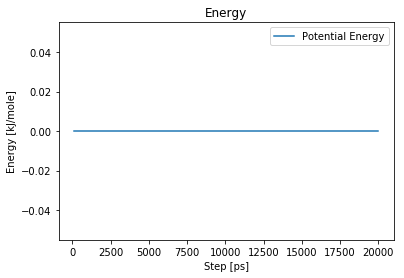

In [65]:
plt.title('Energy')

#plt.plot(csv['Step'], csv['Total_Energy_kJmole'], label='Total Energy')
plt.plot(csv['Step'], csv['Potential_Energy_kJmole'], label='Potential Energy')
#plt.plot(csv['Step'], csv['Kinetic_Energy_kJmole'], label='Kinetic Energy')


plt.xlabel('Step [ps]')
plt.ylabel('Energy [kJ/mole]')
plt.legend()

Surprise, it's an ideal gas.

# Real gas

Let's repeat the same with an real gas, meaning we add interactions!.

## Create the simulation

### System

get the system of the ideal gas

In [66]:
system = deepcopy(simulation.system)
top = deepcopy(simulation.topology)

### Forces

Define Lennard-Jones interactions.

In [67]:
# Add Lennard-Jones interactions using a NonbondedForce
force = mm.NonbondedForce()
force.setNonbondedMethod(mm.NonbondedForce.CutoffPeriodic)

# all particles must have parameters assigned for the NonbondedForce
for index in range(n_particles): 
    # Particles are assigned properties in the same order as they appear in the System object
    force.addParticle(charge, sigma, epsilon)

force.setCutoffDistance(3.0 * sigma) # set cutoff (truncation) distance at 3*sigma
force.setUseSwitchingFunction(True) # use a smooth switching function to avoid force discontinuities at cutoff
force.setSwitchingDistance(2.5 * sigma) # turn on switch at 2.5*sigma
force.setUseDispersionCorrection(True) # use long-range isotropic dispersion correction

system.addForce(force)

0

Use the same settings as the ideal gas

In [68]:
# Create an integrator
integrator = mm.VerletIntegrator(timestep)

# create the simulation
simulation = app.Simulation(topology=top, system=system, integrator=integrator)

# Define starting positions
simulation.context.setPositions(positions_start)

# Define starting positions
simulation.context.setVelocities(velocities_start)

simulation.reporters.append(app.StateDataReporter('thermo.reversible.realgas.csv', n_output,
                                                  step=True,
                                                  potentialEnergy=True,
                                                  kineticEnergy=True,
                                                  totalEnergy=True,
                                                  temperature=True,
                                                 ))
simulation.reporters.append(app.DCDReporter("trajectory.reversible.realgas.dcd", n_output,
                                            enforcePeriodicBox=True))

## Simulation

At first we store the first state of the system.

In [69]:
# store positions
state = simulation.context.getState(getPositions=True)
positions_start = deepcopy(state.getPositions(asNumpy=True))
                           
# write first frame to dcd file
simulation.reporters[1].report(simulation, state)

### Forward

Let's run the simulation for `n_steps` in the forward direction.

In [70]:
simulation.step(n_steps)

#### Visualize

In [71]:
mdtraj_topology = mdtraj.Topology.from_openmm(simulation.topology)
traj = mdtraj.load_dcd('trajectory.reversible.realgas.dcd', top=mdtraj_topology)
view = nglview.show_mdtraj(traj, use_box=True) # gui=True for more options

view.add_spacefill('all')
view.add_unitcell()
# update camera type
view.camera = 'orthographic'

view.center()
view

NGLWidget(count=101)

Also for an real gas a cube is not the stable structure and it falls apart.

### Backward

Let's run the simulation for `n_steps` backward in time.

Therefore, we need to reverse the velocities of our system.

get the velocities

In [72]:
state = simulation.context.getState(getVelocities=True)
velocities = state.getVelocities(asNumpy=True)

reverse the velocities

In [73]:
simulation.context.setVelocities(velocities * -1)

run the simulation

In [74]:
simulation.step(n_steps)

### Visualize

In [75]:
mdtraj_topology = mdtraj.Topology.from_openmm(simulation.topology)
traj = mdtraj.load_dcd('trajectory.reversible.realgas.dcd', top=mdtraj_topology)
view = nglview.show_mdtraj(traj, use_box=True) # gui=True for more options

view.add_spacefill('all')
view.add_unitcell()
# update camera type
view.camera = 'orthographic'

view.center()
view

NGLWidget(count=201)

This time you can see that the simulation is not able to return to the original state.

### Check positions

Additionally, we can check if our positions are exactly the same.

In [77]:
# get the positions at the end
state = simulation.context.getState(getPositions=True)
positions_end = state.getPositions(asNumpy=True)

In [78]:
not_the_same = np.argwhere(
    (positions_start.value_in_unit(angstrom) - positions_end.value_in_unit(angstrom)) != 0)
atom_i, pos_i = not_the_same[0]

In [79]:
print("Positions at the start / end of atom {}\n(different in {}-direction)".format(atom_i, "xyz"[pos_i]))
print(positions_start[atom_i].in_units_of(angstrom))
print(positions_end[atom_i].in_units_of(angstrom))

Positions at the start / end of atom 0
(different in x-direction)
[ 24.27544355  24.27544355  24.27544355] A
[ 26.33368969  23.78418922  23.80094767] A


### Plots

Let's have a look into the energy.

In [83]:
csv = np.genfromtxt('thermo.reversible.realgas.csv', delimiter=',', names=True)
print("Fields : {}".format(csv.dtype.names))

Fields : ('Step', 'Potential_Energy_kJmole', 'Kinetic_Energy_kJmole', 'Total_Energy_kJmole', 'Temperature_K')


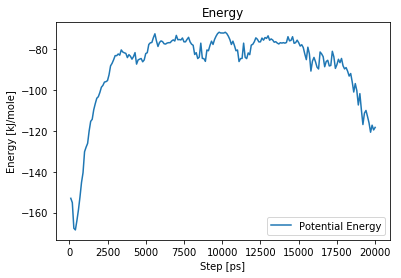

In [84]:
plt.title('Energy')

#plt.plot(csv['Step'], csv['Total_Energy_kJmole'], label='Total Energy')
plt.plot(csv['Step'], csv['Potential_Energy_kJmole'], label='Potential Energy')
#plt.plot(csv['Step'], csv['Kinetic_Energy_kJmole'], label='Kinetic Energy')


plt.xlabel('Step [ps]')
plt.ylabel('Energy [kJ/mole]')
plt.legend()

<span style='color:red'>
    This time the error is due to integration errors, floating point errors and possible cutoff errors.
</span>

> Try only to use `1000` steps for `n_steps`. The simulation should now be able to return to the original state.

> Try to change the `cutoff`.

> Try what happens when you deactivate the *switching function* in the force definition with `force.setUseSwitchingFunction(False)`

> Try to reduce the time step to reduce integration errors. (Note: also increase the number of steps at the same time so you simulate the same amount of time ! )